# Testing the normality of Grid'5000 values

In [1]:
library(tidyverse)
library(ggplot2)
library(anytime)
library(broom)

csv_url = 'https://gitlab.in2p3.fr/cornebize/g5k_test/raw/master/stats.csv'
csvmon_url = 'https://gitlab.in2p3.fr/cornebize/g5k_test/raw/master/stats_monitoring.csv'

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──
✔ ggplot2 3.3.2     ✔ purrr   0.3.3
✔ tibble  2.1.3     ✔ dplyr   1.0.2
✔ tidyr   1.0.0     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


In [2]:
df = read.csv(url(csv_url)) %>%
    mutate(timestamp = anytime(start_time))
str(df)

'data.frame':	133960 obs. of  40 variables:
 $ cluster            : Factor w/ 10 levels "chetemi","chiclet",..: 3 3 3 3 3 3 3 3 3 3 ...
 $ node               : int  8 8 9 9 1 1 2 2 3 3 ...
 $ cpu                : int  0 1 0 1 0 1 0 1 0 1 ...
 $ jobid              : int  1870101 1870101 1870102 1870102 1870094 1870094 1870095 1870095 1870096 1870096 ...
 $ start_time         : int  1560547719 1560547719 1560547725 1560547725 1560547806 1560547806 1560547813 1560547813 1560547827 1560547827 ...
 $ expfile_hash       : Factor w/ 138 levels "07903fe17654a82bcd0b7bb463b7aa9531a0fa4c28cd63c3786e081306f3b8cc",..: 99 99 99 99 99 99 99 99 99 99 ...
 $ function.          : Factor w/ 1 level "dgemm": 1 1 1 1 1 1 1 1 1 1 ...
 $ intercept          : num  1.88e-06 2.36e-06 1.83e-06 1.94e-06 2.01e-06 ...
 $ intercept_residual : num  2.47e-07 1.87e-06 2.39e-07 5.35e-07 3.87e-07 ...
 $ k                  : num  3.45e-07 3.83e-07 3.90e-07 4.05e-07 4.32e-07 ...
 $ k_residual         : num  6.04e-08 1.06e

In [3]:
dfmon = read.csv(url(csvmon_url)) %>%
    mutate(timestamp = anytime(start_time))
str(dfmon)

'data.frame':	105694 obs. of  15 variables:
 $ cluster         : Factor w/ 9 levels "chetemi","dahu",..: 9 9 9 9 9 9 9 9 9 9 ...
 $ node            : int  1 1 1 1 2 2 2 2 3 3 ...
 $ cpu             : int  0 1 2 3 0 1 2 3 0 1 ...
 $ jobid           : int  1895522 1895522 1895522 1895522 1895522 1895522 1895522 1895522 1895522 1895522 ...
 $ start_time      : int  1574605510 1574605510 1574605510 1574605510 1574605510 1574605510 1574605510 1574605510 1574605510 1574605510 ...
 $ expfile_hash    : Factor w/ 75 levels "07903fe17654a82bcd0b7bb463b7aa9531a0fa4c28cd63c3786e081306f3b8cc",..: 16 16 16 16 16 16 16 16 16 16 ...
 $ mean_frequency  : num  2.08 2.19 2.2 2.34 2.19 ...
 $ mean_temperature: num  81.3 76.4 68.3 67 80.9 ...
 $ std_frequency   : num  0.0355 0.0389 0.0412 0.0414 0.0491 ...
 $ std_temperature : num  1.62 1.66 1.05 1.18 2.18 ...
 $ mean_power_cpu  : num  NA NA NA NA NA NA NA NA NA NA ...
 $ std_power_cpu   : num  NA NA NA NA NA NA NA NA NA NA ...
 $ mean_power_dram : num  NA

In [4]:
test_normality <- function(df, cluster_name, col, thresh=0.05, show_hist=F) {
    df = df %>%
        filter(timestamp > anytime("2020-12-15")) %>%
        filter(cluster==cluster_name) %>%
        mutate(my_col=.data[[col]]) %>%  # just renaming the interest col, for convenience
        group_by(cluster, node, cpu) %>%
        mutate(cpu_id=interaction(node, cpu, sep=':'))
    shapiro = df %>%
        filter(timestamp > anytime("2020-12-15")) %>%
        filter(cluster==cluster_name) %>%
        mutate(x=.data[[col]]) %>%  # just renaming the interest col, for convenience
        group_by(cluster, node, cpu) %>%
        mutate(N_Samples = n()) %>%
        nest() %>%
        mutate(Shapiro = map(data, ~ shapiro.test(.x$my_col))) %>%
        mutate(glance_shapiro = Shapiro %>% map(glance)) %>%
        unnest(glance_shapiro) %>%
        select(-data, -Shapiro) %>%
        ungroup() %>%
        mutate(below_thresh=p.value <= thresh)
    df = df %>% full_join(shapiro, by=c("cluster", "node", "cpu"))
    shapiro_plot = shapiro %>% {(
        ggplot(.)
            + aes(x=node, y=p.value, color=factor(cpu), shape=below_thresh)
            + geom_point()
            + theme_bw()
            + geom_hline(yintercept=thresh, linetype="dashed", color="gray")
            + labs(color="CPU", shape="Below threshold")
            + scale_color_brewer(palette="Dark2")
            + scale_shape_manual(values=c(19, 4))
            + ggtitle(paste("Normality test for cluster ", cluster_name, ", parameter ", col, "\n(P-value threshold of ", thresh, ")", sep=""))
        )}
    print(shapiro_plot)
    histo_plot = df %>% {(
        ggplot(.)
            + aes(x=my_col, fill=below_thresh)
            + geom_histogram()
            + facet_grid(node~cpu, labeller="label_both")
            + theme_bw()
            + labs(fill="Below threshold", x=col)
            + scale_fill_brewer(palette="Dark2")
            + ggtitle(paste("Distribution of parameter", col))
    )}
    if(show_hist) {
        print(histo_plot)
    }
}

## Yeti

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


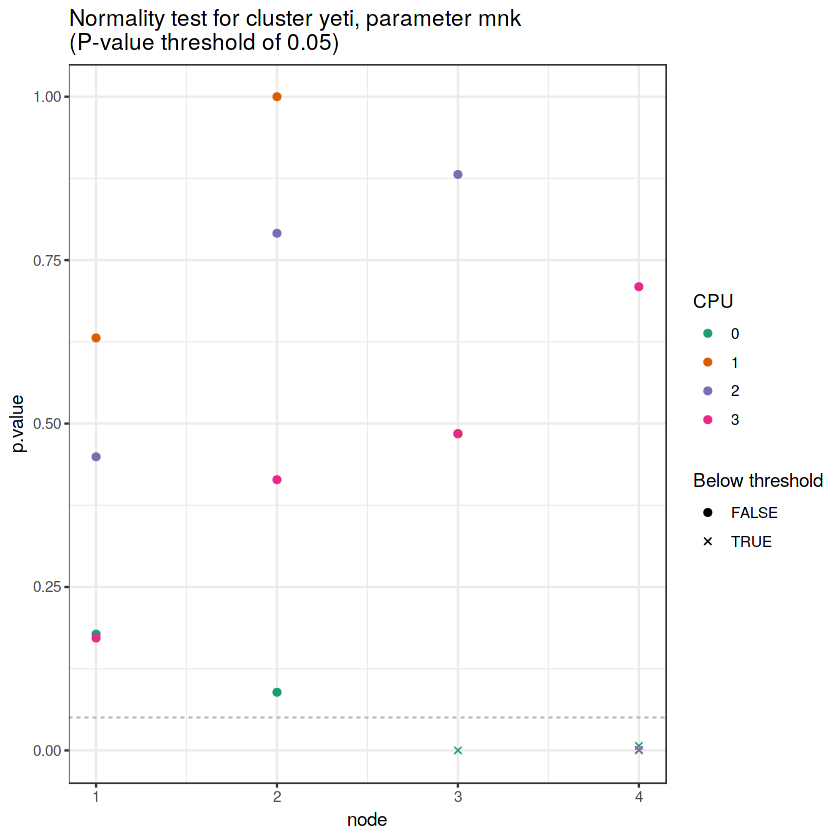

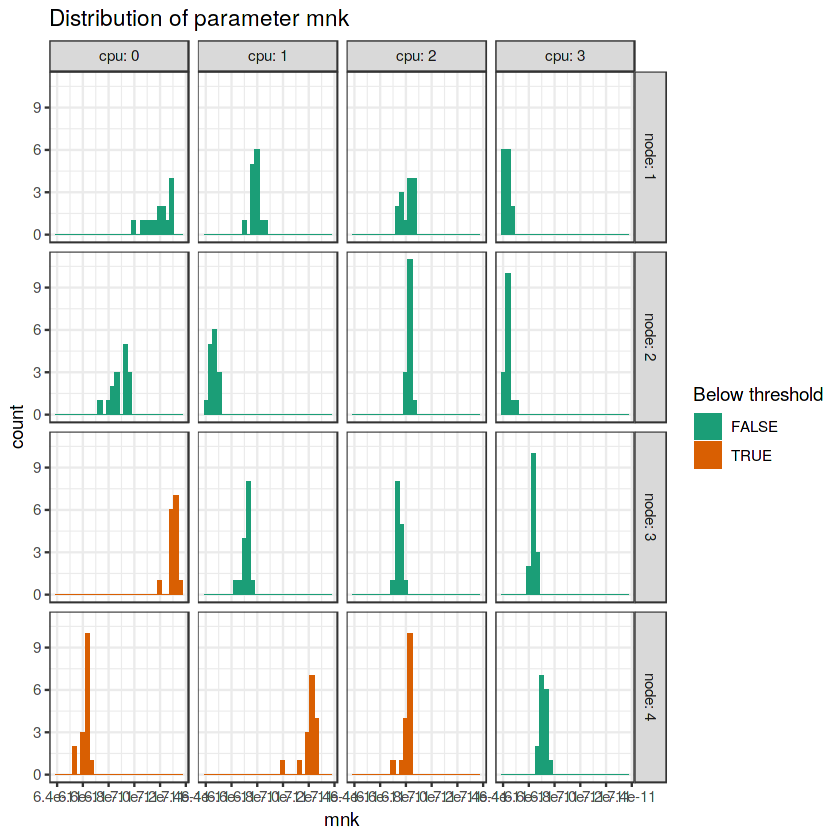

In [5]:
test_normality(df, "yeti", "mnk", show_hist=T)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


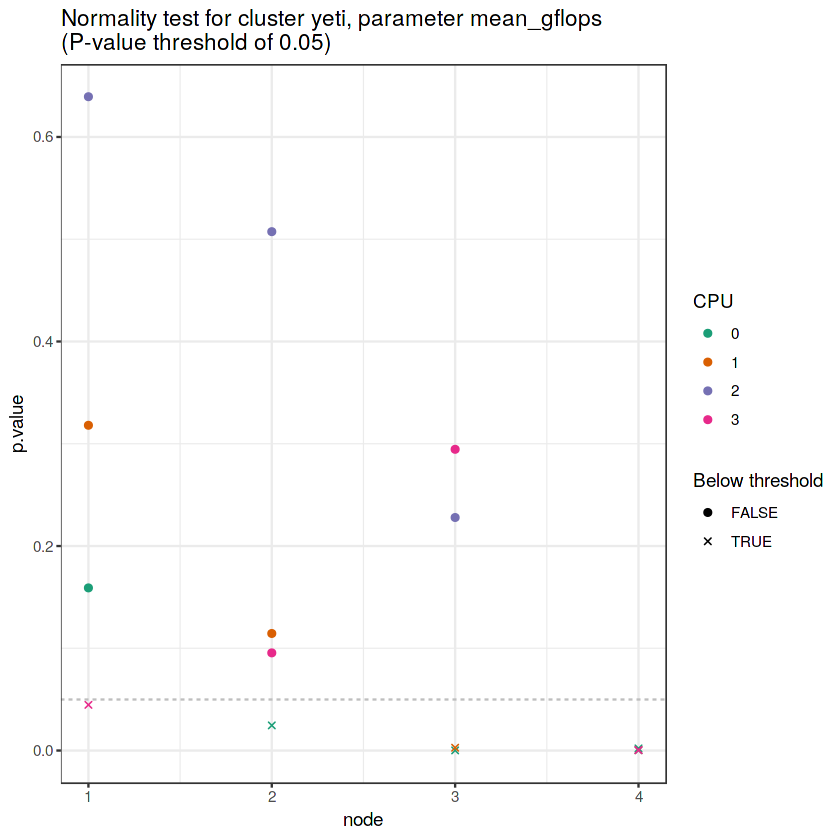

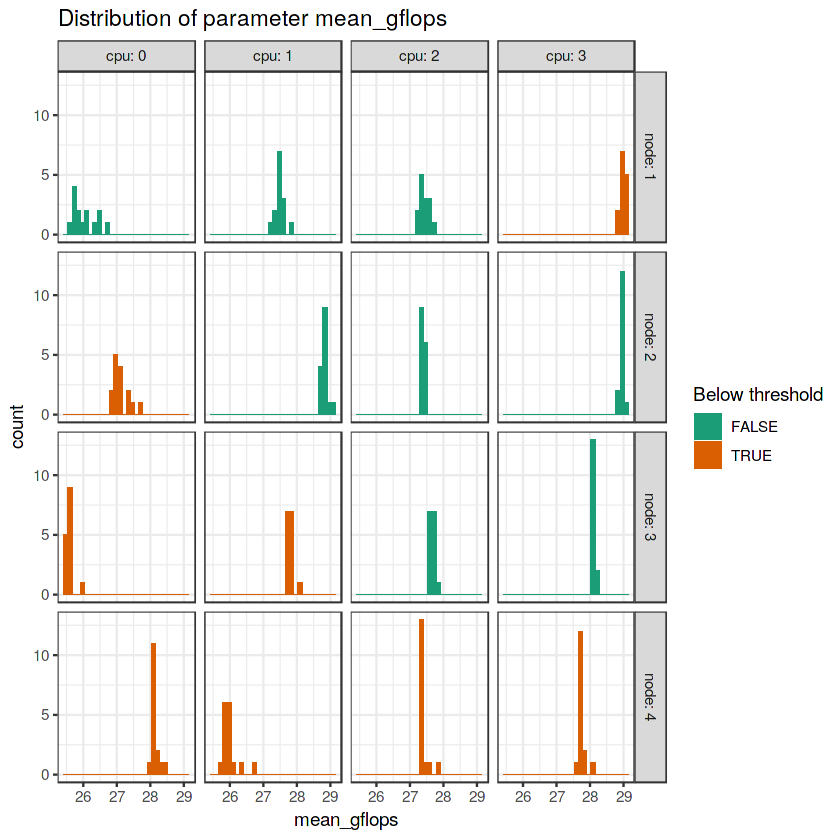

In [6]:
test_normality(df, "yeti", "mean_gflops", show_hist=T)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


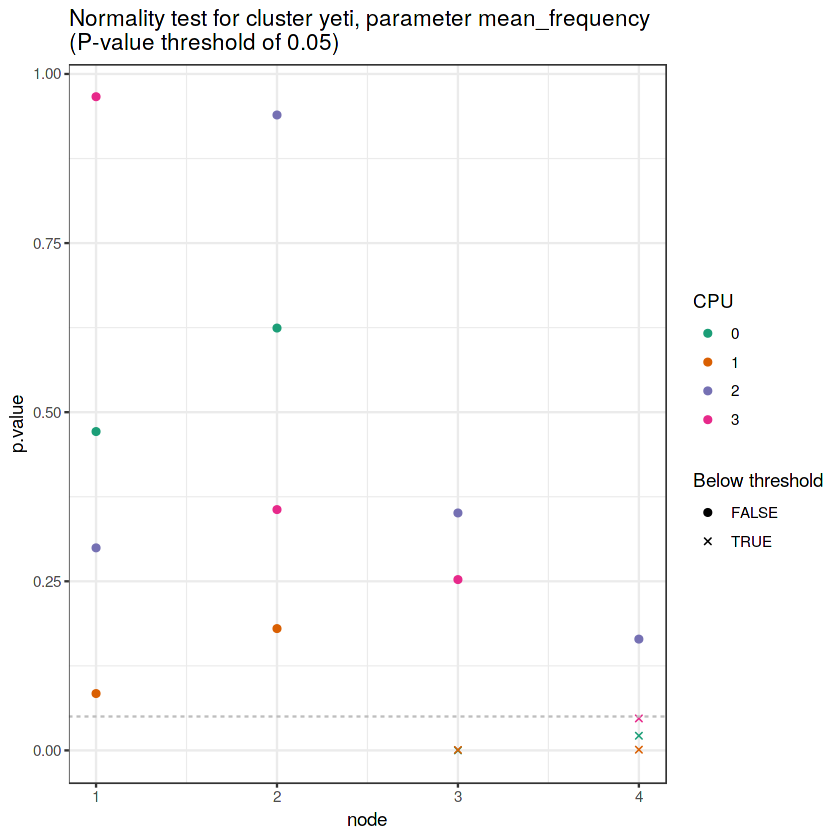

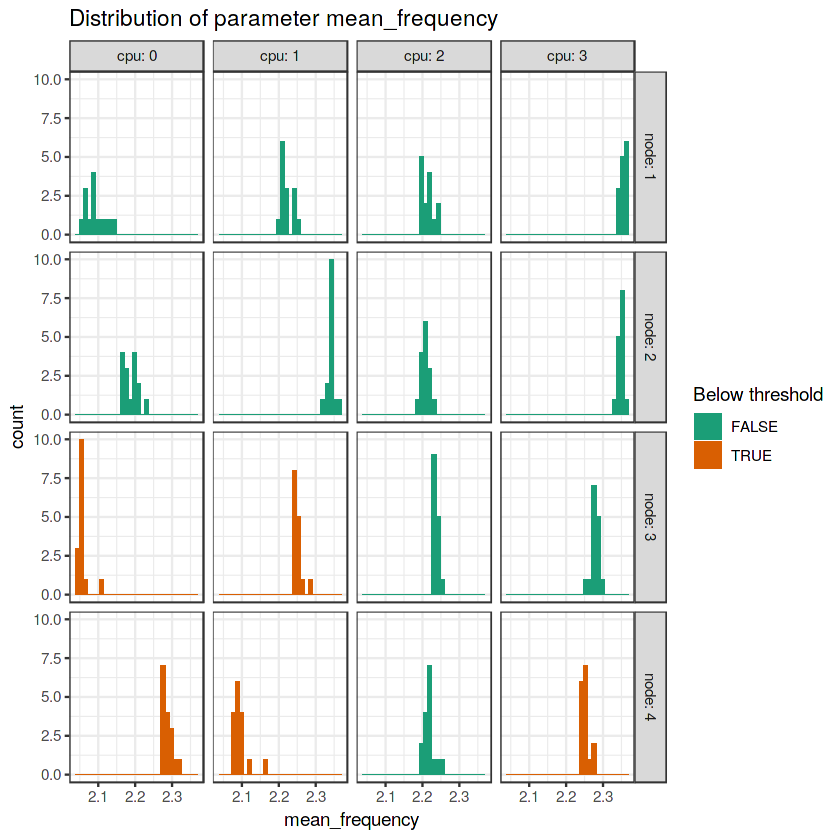

In [7]:
test_normality(dfmon, "yeti", "mean_frequency", show_hist=T)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


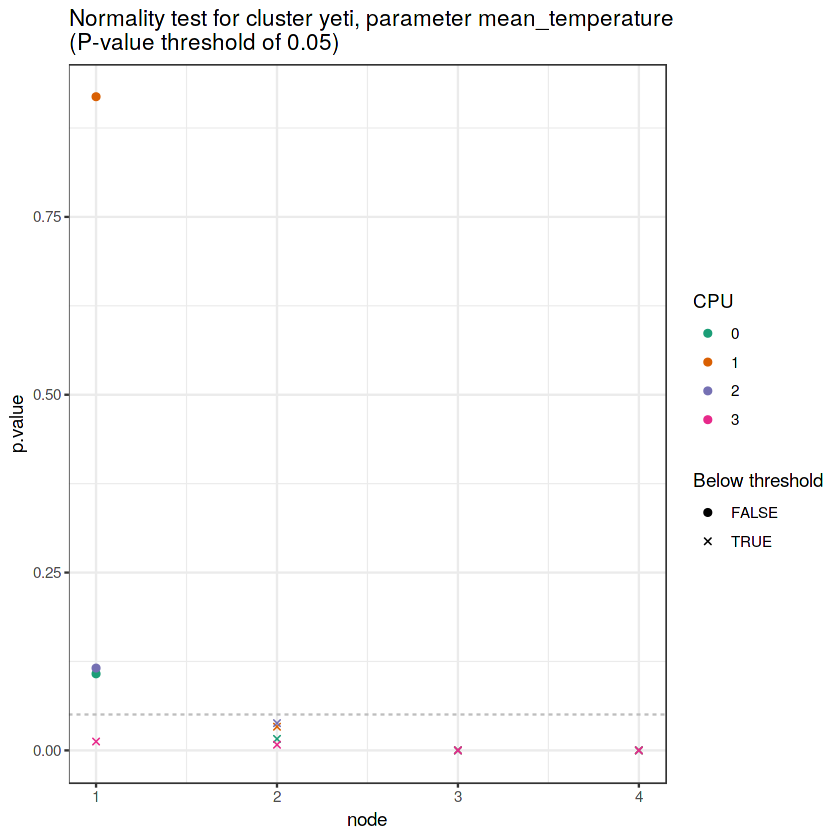

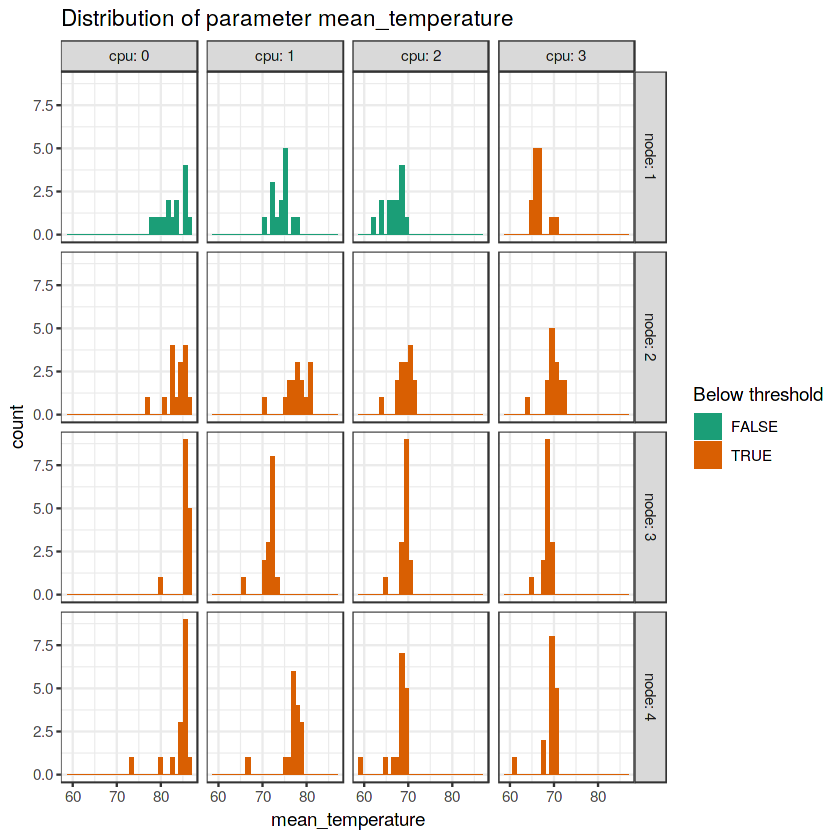

In [8]:
test_normality(dfmon, "yeti", "mean_temperature", show_hist=T)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


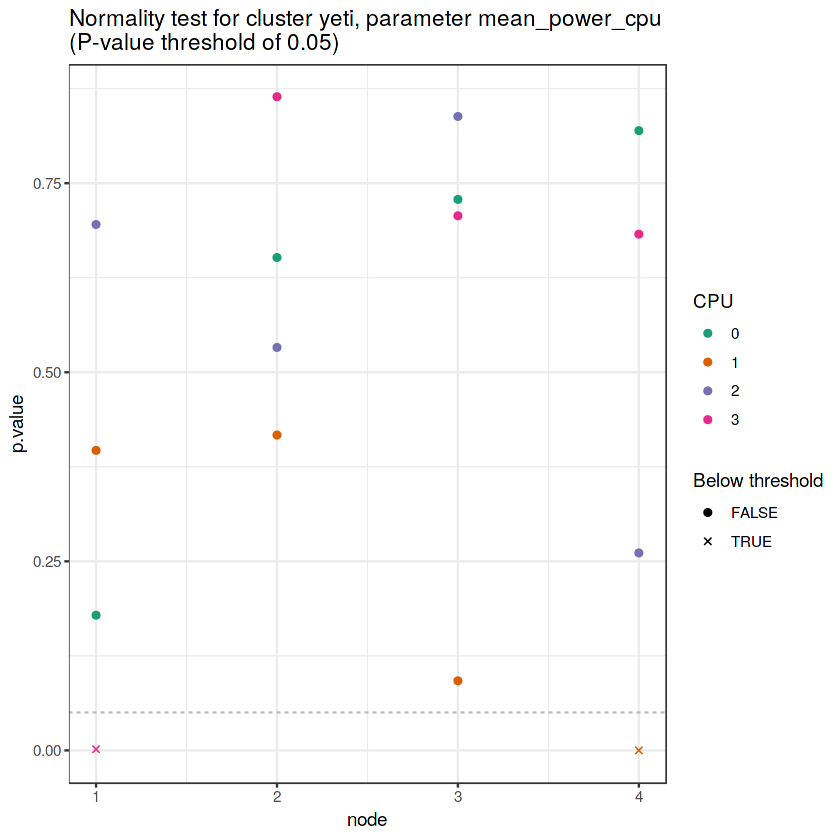

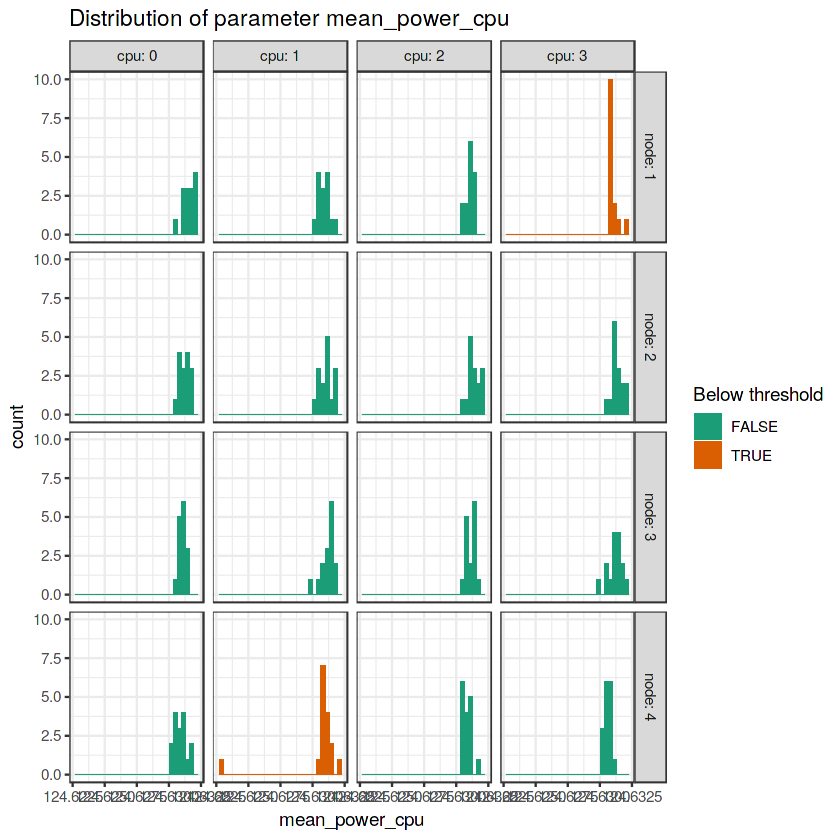

In [9]:
test_normality(dfmon, "yeti", "mean_power_cpu", show_hist=T)

## Dahu

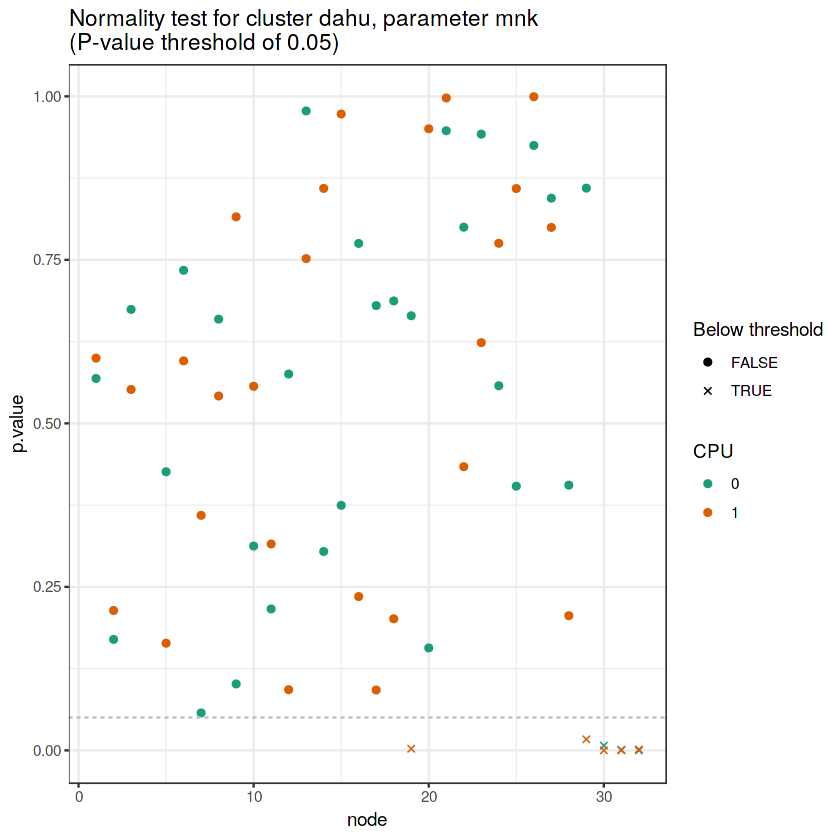

In [10]:
test_normality(df, "dahu", "mnk")

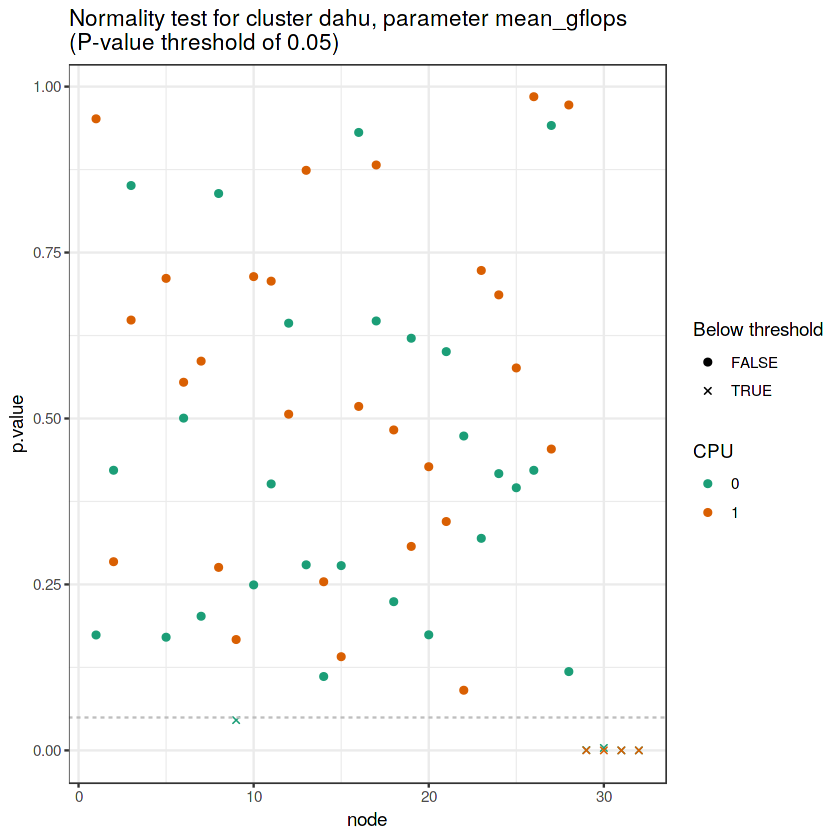

In [11]:
test_normality(df, "dahu", "mean_gflops")

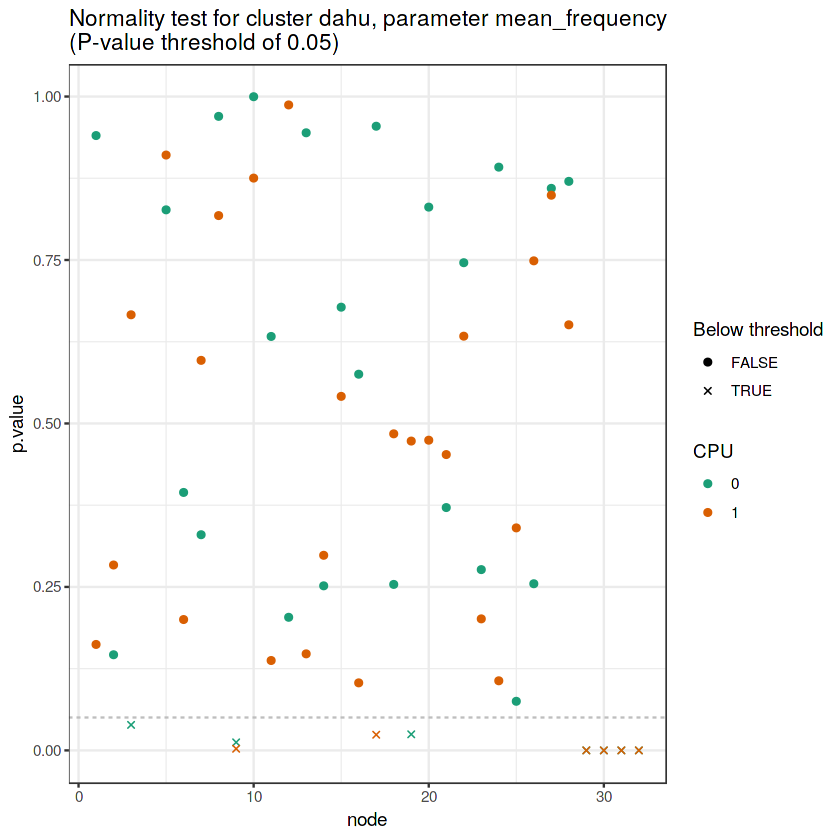

In [12]:
test_normality(dfmon, "dahu", "mean_frequency")

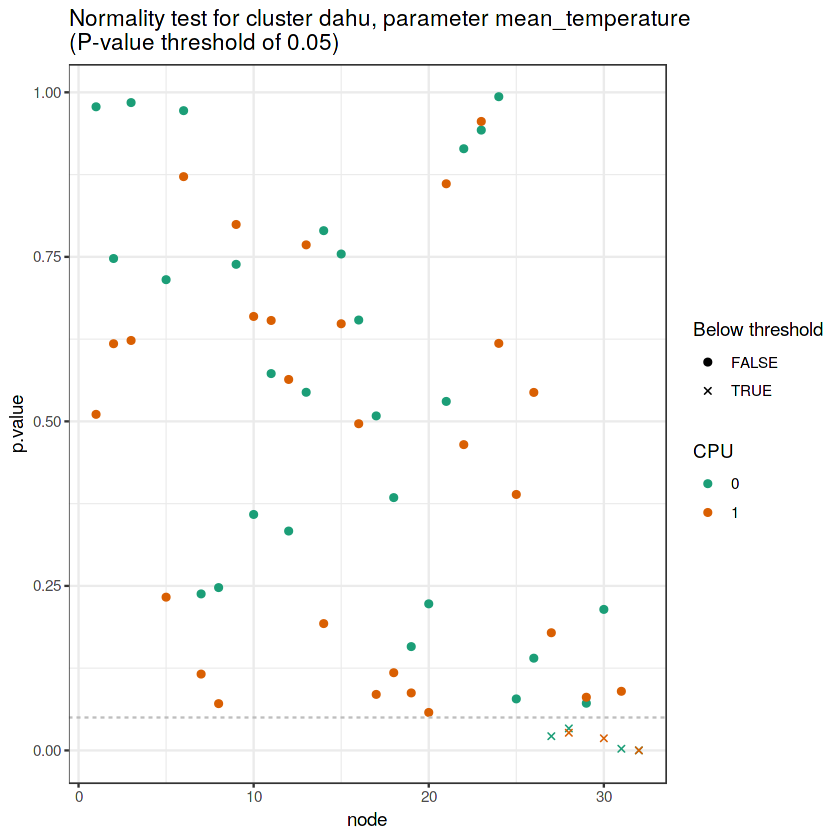

In [13]:
test_normality(dfmon, "dahu", "mean_temperature")

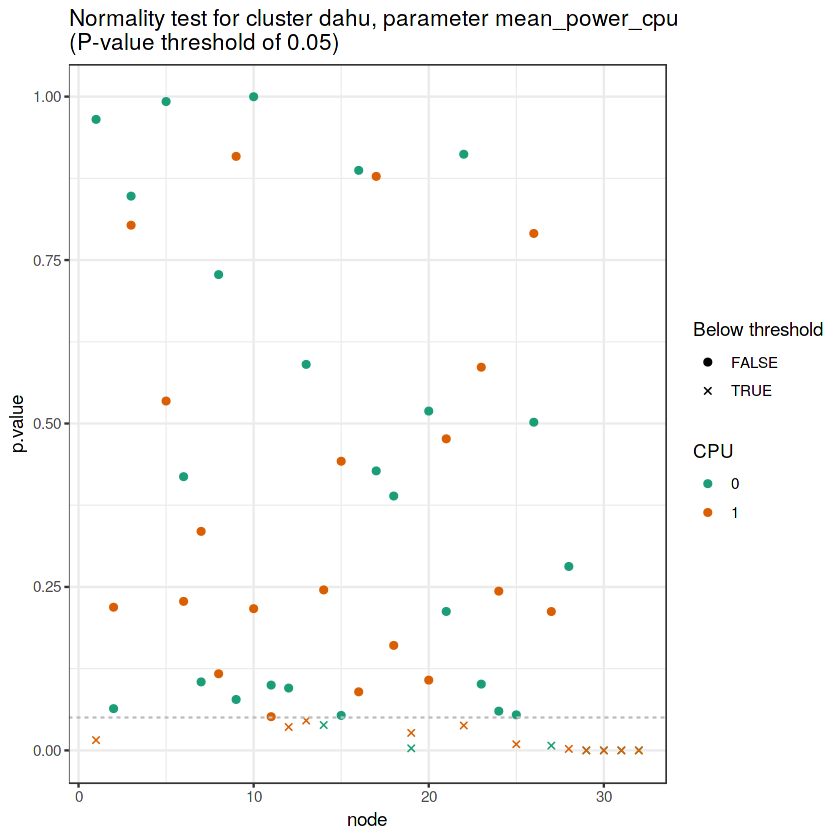

In [14]:
test_normality(dfmon, "dahu", "mean_power_cpu")

## Gros

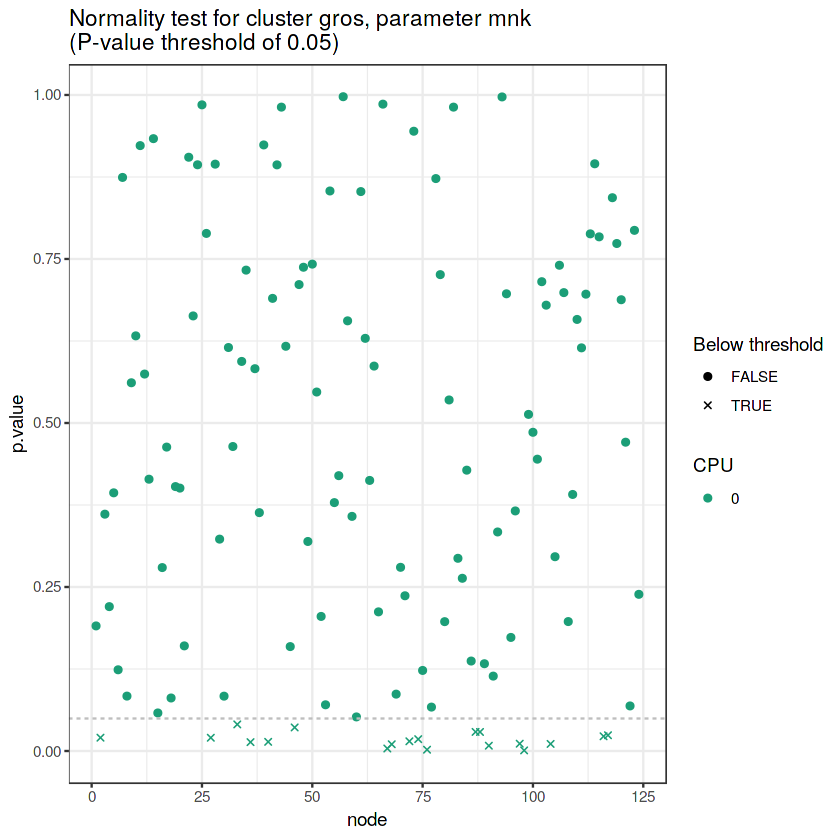

In [15]:
test_normality(df, "gros", "mnk")

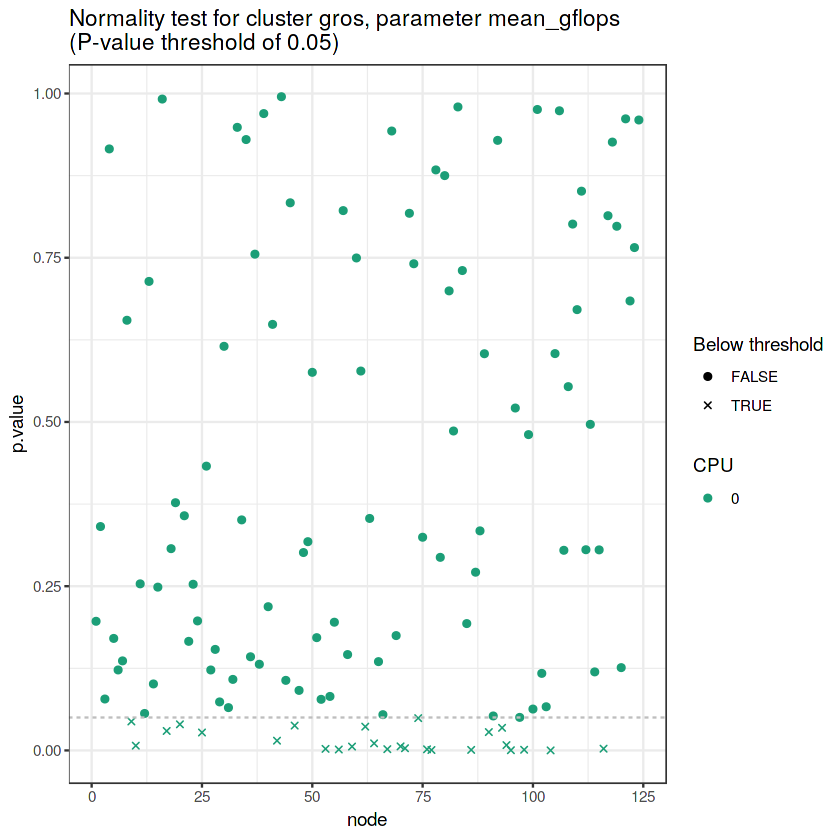

In [16]:
test_normality(df, "gros", "mean_gflops")

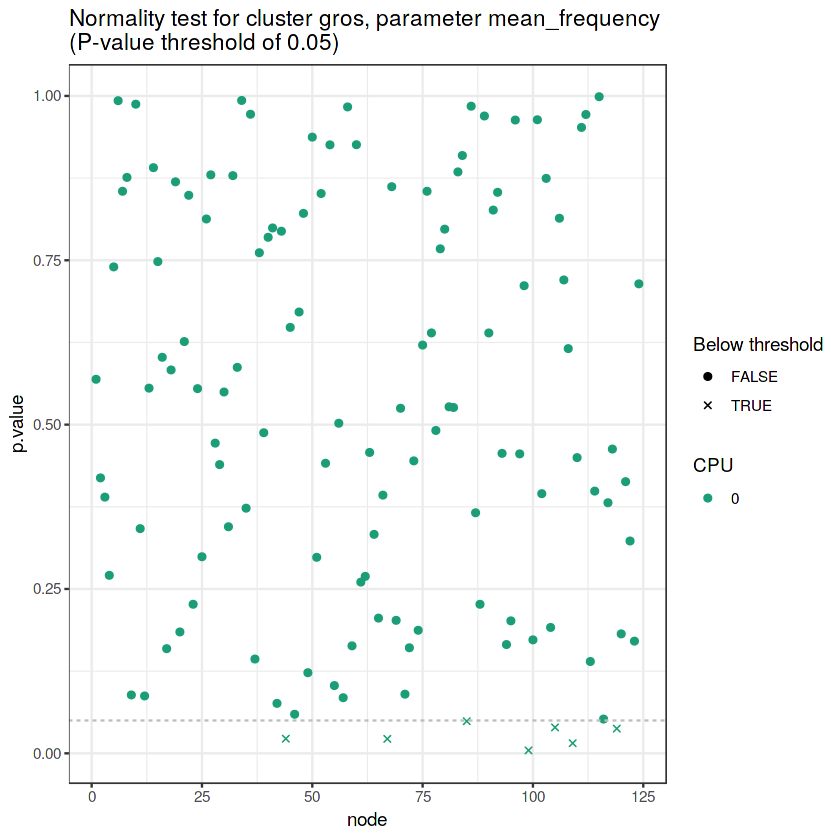

In [17]:
test_normality(dfmon, "gros", "mean_frequency")

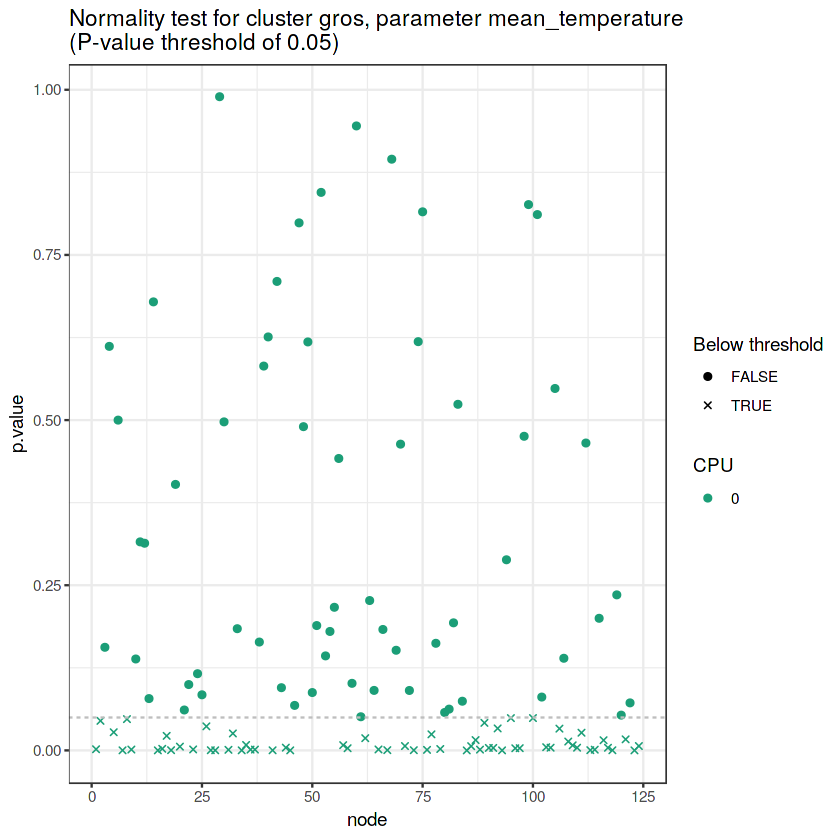

In [18]:
test_normality(dfmon, "gros", "mean_temperature")

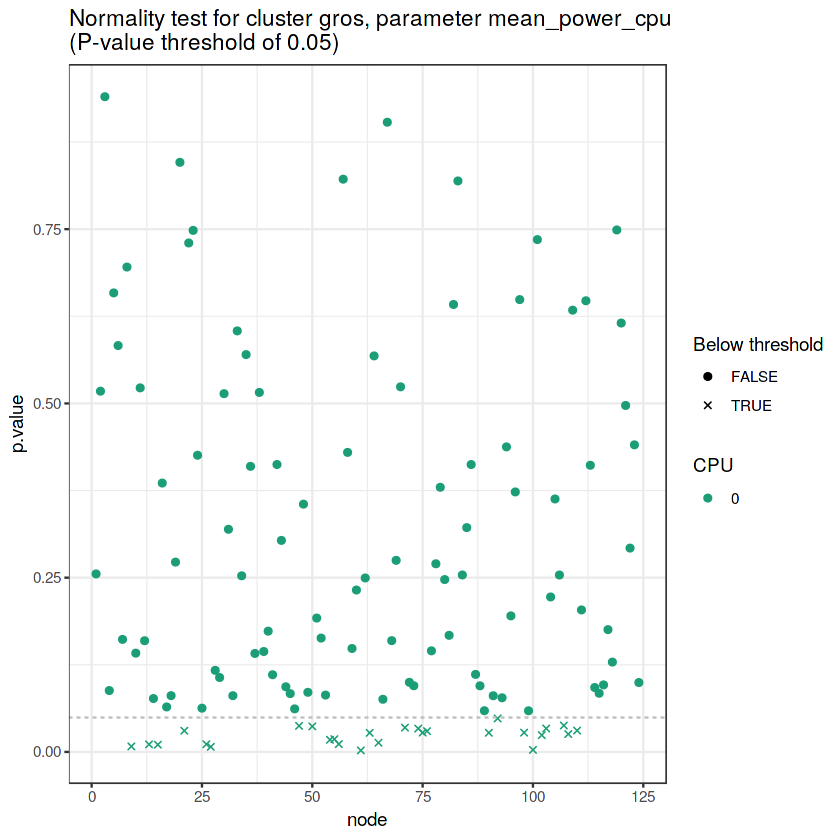

In [19]:
test_normality(dfmon, "gros", "mean_power_cpu")